In [4]:
import sys
import os
sys.path.insert(0, os.getcwd()+'/src/')
sys.path.insert(0, '/home/mcarenso/code/stage-2023-multiscale-extremes/scripts/src/')
from myImports import *
%matplotlib inline
%load_ext autoreload

In [5]:
## Which cacatoes data ? SAM 300K 2D
cacatoes_dir_path = "/homedata/fiolleau/RCE/CACATOES/"
sam_dir_path = "/bdd/MT_WORKSPACE/REMY/RCEMIP/SAM/300K/"

In [11]:
n_days = 20 # number of days to extract 

## SAM : Mean

In [12]:
ds_SAM_Prec_mean = xr.open_dataset(f"/homedata/mcarenso/outputs/rcemip_prec_1°x1day_remeshed_by_mean_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()

In [13]:
#Compute Distribution for ds_SAM_Prec_mean.
ds_SAM_Prec_mean_shape = (64, 4, n_days)
#ds_SAM_Prec_mean = ds_SAM_Prec_mean.reshape(-1)
dist_SAM_Prec_mean = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_mean.computeDistribution(sample = ds_SAM_Prec_mean)
dist_SAM_Prec_mean.storeSamplePoints(sample = ds_SAM_Prec_mean)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


# SAM : max

In [15]:
ds_SAM_Prec_max = xr.open_dataset(f"/homedata/mcarenso/outputs/rcemip_prec_1°x1day_remeshed_by_max_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()

In [16]:
#Compute Distribution for dsSAM_Prec_max

#ds_SAM_Prec_max = ds_SAM_Prec_max.flatten()
dist_SAM_Prec_max = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_max.computeDistribution(sample = ds_SAM_Prec_max)
dist_SAM_Prec_max.storeSamplePoints(sample = ds_SAM_Prec_max)

## Spatial location 



In [ ]:
ds_SAM_Prec_max

: 

# SAM : Mean vs Max

In [8]:
# fig,axs = plt.subplots(ncols=2,figsize=(10,4))

# # distribution on log-log
# ax = axs[0]
# ax.plot(dist_SAM_Prec_Mean.percentiles,dist_SAM_Prec_Mean.density,'k',label='no noise')
# ax.plot(dist_SAM_Prec_max.percentiles,dist_SAM_Prec_max.density,'k--',label='w/ noise')
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_xlabel('lognormal, inverse logarithmic bins')
# ax.set_ylabel('density')

# # distribution on inverse logarithmic ranks
# ax = axs[1]
# _,h1 = subplotRanksILog(ax,dist_SAM_Prec_Mean.ranks,dist_SAM_Prec_Mean.percentiles,col='k',ltype='-',labels='SAM Mean Precip')
# _,h2 = subplotRanksILog(ax,dist_SAM_Prec_max.ranks,dist_SAM_Prec_max.percentiles,col='k',ltype='--',labels='SAM Precip max',setframe=False) 

# ax.set_xlabel('Percentile ranks',labelpad=30)
# ax.set_ylabel('Percentiles')

# plt.legend(loc='upper left',handles=h1+h2)
# plt.show()

In [20]:
# Exploratory data
FracPrec = xr.open_dataarray("/homedata/mcarenso/outputs/rcemip_prec_1°x1day_remeshed_by_fracPrec_with_300K_for_20days.nc")
VertSpeed = xr.open_dataarray("/homedata/mcarenso/outputs/rcemip_w_1°x1day_remeshed_by_mean_with_300K_for_20days.nc")
VertSpeed_by_MCS = xr.open_dataarray("/homedata/mcarenso/outputs/rcemip_w_1°x1day_remeshed_by_mean_with_300K_for_20days.nc")


In [21]:
# Joint distribution
jd_Mean_Max_IL = cs.JointDistribution(name='Mean vs Max',distribution1=dist_SAM_Prec_mean, distribution2=dist_SAM_Prec_max)
FracPrec_densified = jd_Mean_Max_IL.computeNormalizedDensity(ds_SAM_Prec_mean, ds_SAM_Prec_max, data = FracPrec.values)
VertSpeed_5km_densified = jd_Mean_Max_IL.computeNormalizedDensity(ds_SAM_Prec_mean, ds_SAM_Prec_max, data = VertSpeed.values)
VertSpeed_by_MCS_5km_densified = jd_Mean_Max_IL.computeNormalizedDensity(ds_SAM_Prec_mean, ds_SAM_Prec_max, data = VertSpeed_by_MCS.values)

/home/mcarenso/code/conditional-stats/src/conditionalstats.py:1126: RuntimeWarning: Mean of empty slice
  data_over_density[i1, i2] = np.nanmean(data[data_idx])


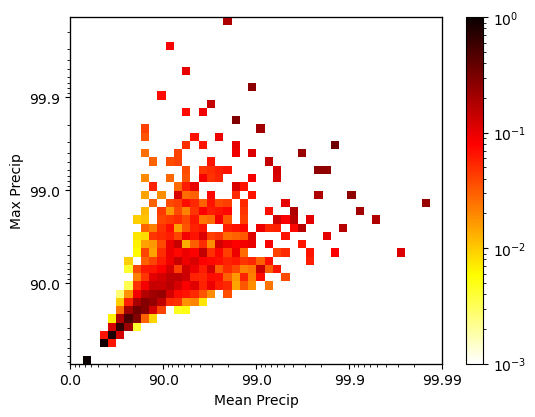

In [22]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# values
Z = jd_Mean_Max_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log', cmap = 'hot_r') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()
## TODO : add the imshow of Mean Precip and Max Precip over density

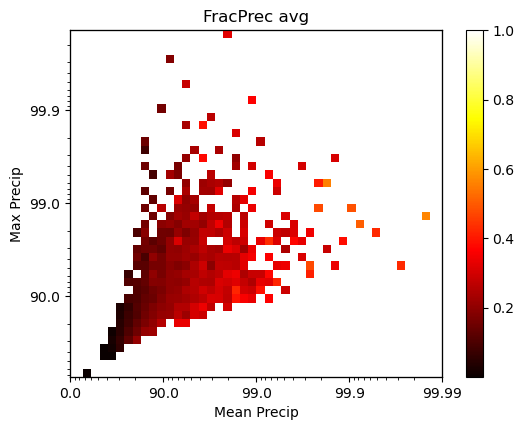

In [23]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# values
Z = FracPrec_densified.T
h = showJointHistogram(ax_show, Z, scale = 'lin', cmap = 'hot') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.title("FracPrec avg")
plt.colorbar(h)
plt.show()

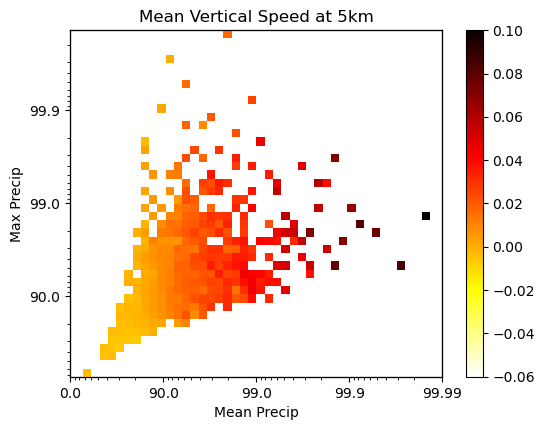

In [24]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# values
Z = VertSpeed_5km_densified.T
h = showJointHistogram(ax_show, Z, scale = 'lin', vmin = -0.06, vmax = 0.1, cmap = 'hot_r') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.title("Mean Vertical Speed at 5km")
plt.colorbar(h)
plt.show()

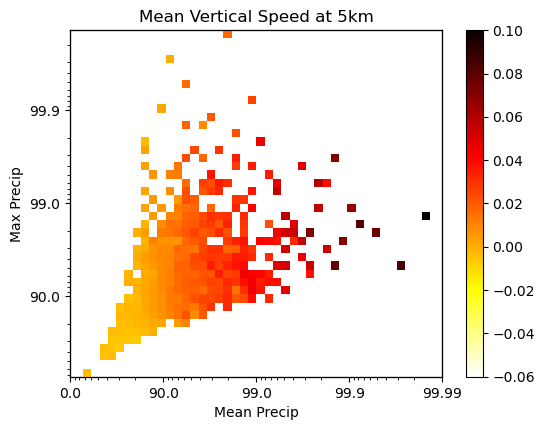

In [25]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# values
Z = VertSpeed_by_MCS_5km_densified.T
h = showJointHistogram(ax_show, Z, scale = 'lin', vmin = -0.06, vmax = 0.1, cmap = 'hot_r') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.title("Mean Vertical Speed at 5km")
plt.colorbar(h)
plt.show()


In [28]:
path = "/homedata/mcarenso/outputs/rcemip_w_1°x1day_remeshed_by_max_by_MCS_with_300K_for_20days.nc"
MaxVertSpeed = xr.open_dataarray(path)
MaxVertSpeed_5km_densified = jd_Mean_Max_IL.computeNormalizedDensity(ds_SAM_Prec_mean, ds_SAM_Prec_max, data = MaxVertSpeed.values)

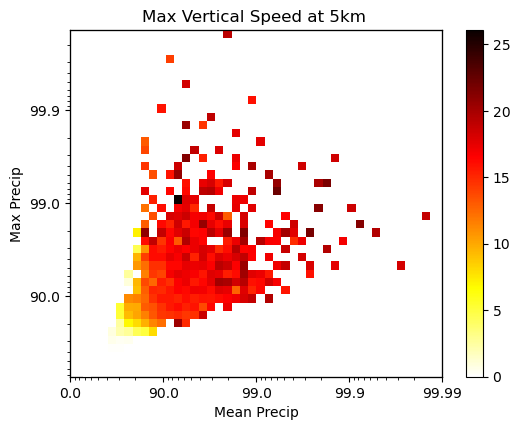

In [29]:
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# values
Z = MaxVertSpeed_5km_densified.T
h = showJointHistogram(ax_show, Z, scale = 'lin', vmin = np.nanmin(Z), vmax = np.nanmax(Z), cmap = 'hot_r') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.title("Max Vertical Speed at 5km ")
plt.colorbar(h)
plt.show()

In [31]:
path = "/homedata/mcarenso/outputs/rcemip_prec_1°x1day_remeshed_by_growthRate_meanMean_with_300K_for_20days.nc"
GrowthRateMeanMean = xr.open_dataarray(path)
GrowthRateMeanMean_densified = jd_Mean_Max_IL.computeNormalizedDensity(ds_SAM_Prec_mean, ds_SAM_Prec_max, data = GrowthRateMeanMean.values)

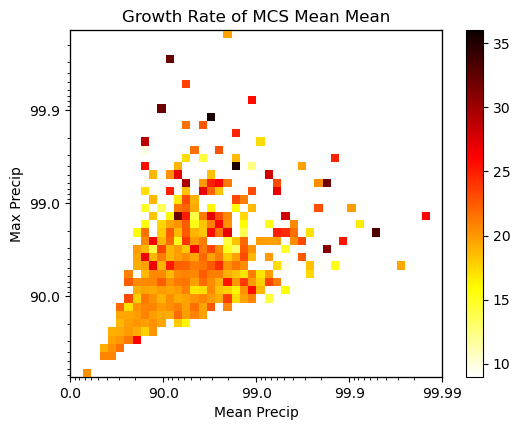

In [32]:
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_max.ranks, xlabel = "Mean Precip", ylabel = "Max Precip") ## the given ax object must not be ax_show. 

# values
Z = GrowthRateMeanMean_densified.T
h = showJointHistogram(ax_show, Z, scale = 'lin', vmin = 9, vmax = 36, cmap = 'hot_r') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.title("Growth Rate of MCS Mean Mean")
plt.colorbar(h)
plt.show()

# Plot Growth rate 

### Retrieve MCS labels over x,y,t

In [33]:
stringSST="300"
#TOOCAN segmentation masks (les labels des objets MCS, dans la grille originale x,y,t)
file_seg='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/TOOCAN_2.07_SAM_RCE_large'+stringSST+'_2D_irtb.nc'

MCS_labels = xr.open_dataarray(file_seg)
MCS_labels = MCS_labels.isel(time=slice(48*n_days))
MCS_labels

<xarray.DataArray 'MCS_label' (time: 960, latitude: 128, longitude: 2048)>
[251658240 values with dtype=float64]
Dimensions without coordinates: time, latitude, longitude
Attributes:
    units:           
    standard_name:  MCS_label
    long_name:      MCS labellisation

### Retrieve the tracking file to get all infoabout MCS per label

In [35]:
ds_SAM_shape = (n_days, 4, 64)

from myFuncs import calculate_first_derivative, classify_derivative
def idx_by_label(labels):
    idxs = [label_list.index(label) for label in labels]
    return idxs

file_tracking='/bdd/MT_WORKSPACE/MCS/RCE/SAM/TOOCAN/TOOCAN_v2022_04/irtb/FileTracking/TOOCAN-SAM_RCE_large'+stringSST+'_2D_irtb.dat.gz'

from load_TOOCAN_DYAMOND_modif_BenAndMax import load_TOOCAN_DYAMOND
MCS = load_TOOCAN_DYAMOND(file_tracking)
label_list = [MCS[i].label for i in range(len(MCS))]

### Iterate over the bins of a distrib, get the labels of the bin, compute the growth through the MCS.clusters.surf235k

In [83]:
mean_growth = []
max_growth = []

for i,bin_loc in enumerate(dist_SAM_Prec_mean.bin_locations):
    bin_mean_growth = []
    bin_max_growth = []
    ## Retrieve coord array of (x,y,t)s per bins. tuple form is usefull for subscritapility and array form is usefull for iterating over.
    coord_subs = np.unravel_index(bin_loc, ds_SAM_shape) ## 3-uplet of 1D array that represents  time, y and x. access like idxs_subs[2][i] for the x value of the ith index
    coord_read = np.vstack(coord_subs).T # np.array of coordinates np.array(time, y, x)

    ## Get the labels of MCS for these (x,y,t)s, for now remove Nans and don't discriminate MCS that may occurs multiple time. 
    labels = MCS_labels.values[coord_subs]
    labels_no_nan = [x for x in labels if not math.isnan(x)]
    coord_no_nan = [idx for i, idx in enumerate(coord_read) if not math.isnan(labels[i])] ## coord correspond to (x,y,t), used as indexing for original dataset
    MCSs = [MCS[idx] for idx in idx_by_label(labels_no_nan)]                              ## while this idx correspond to the indexing of MCS within the tracking file.
    assert len(labels_no_nan)==len(MCSs) and len(MCSs)==len(coord_no_nan)
    for i in range(len(MCSs)):
        assert coord_no_nan[i][0] >= MCSs[i].TimeInit, "MCS time should be superior to its Time Init"
        surf = np.array(MCSs[i].clusters.surf235k_km2)
        dsurf = calculate_first_derivative(surf)
        MClass, pos, neg = classify_derivative(dsurf)
        if (MClass==2) or MClass == 1 :
            bin_mean_growth.append(np.mean(dsurf[dsurf>0]))
            bin_max_growth.append(np.max(dsurf[dsurf>0]))
        elif MClass==2.1:
            bin_mean_growth.append(mean_growth = np.mean(dsurf[pos[0]:neg[0]]))
            bin_max_growth.append(np.max(dsurf[pos[0]:neg[0]]))
    mean_growth.append(np.mean(mean_growth))
    max_growth.append(np.mean(max_growth))

In [ ]:
# Max_coords = np.vstack(np.where(ds_SAM_Prec_max.reshape(n_days, 4, 64)>dist_SAM_Prec_max.percentiles[-14])).T
# Mean_coords = np.vstack(np.where(ds_SAM_Prec_mean.reshape(n_days, 4, 64)>dist_SAM_Prec_mean.percentiles[-14])).T
# Mean_coords

array([[ 0,  0, 32],
       [ 0,  2, 32],
       [ 0,  3, 31],
       [ 0,  3, 32],
       [ 0,  3, 33],
       [ 2,  0,  7],
       [ 2,  0, 15],
       [ 2,  1, 16],
       [ 2,  3, 15],
       [ 4,  3, 33],
       [12,  3, 33]])

# SAM : Mean vs Mean (test)

In [21]:
# Joint distribution
jd_Mean_Mean_IL = cs.JointDistribution(name='Mean vs Mean',distribution1=dist_SAM_Prec_mean, distribution2=dist_SAM_Prec_mean)
jd_Mean_Mean_IL.computeNormalizedDistribution(ds_SAM_Prec_mean.reshape(n_days, 4, 64), ds_SAM_Prec_mean.reshape(n_days, 4, 64))

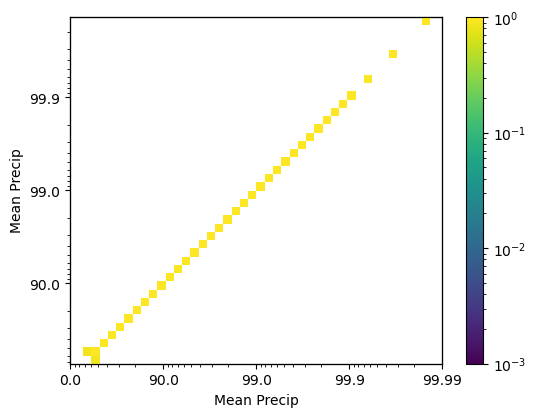

In [22]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_mean.ranks, xlabel = "Mean Precip", ylabel = "Mean Precip") ## the given ax object must not be ax_show. 

# values
Z = jd_Mean_Mean_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

# SAM : Trunc Mean 

In [24]:
diag = "truncMean"
ds_SAM_Prec_truncMean = xr.open_dataset(f"../outputs/rcemip_prec_1°x1day_remeshed_by_"+diag+f"_with_300K_for_{n_days}days.nc")["Prec"].to_numpy()

In [25]:
#Compute Distribution for dsSAM_Prec_truncMean

ds_SAM_Prec_truncMean = ds_SAM_Prec_truncMean.flatten()
dist_SAM_Prec_truncMean = cs.Distribution(name="SAM Precipitation truncMean", bintype = "invlogQ", nd = 4, fill_last_decade=True)
dist_SAM_Prec_truncMean.computeDistribution(sample = ds_SAM_Prec_truncMean)
dist_SAM_Prec_truncMean.storeSamplePoints(sample = ds_SAM_Prec_truncMean)

## SAM : Trunc Mean vs Mean 

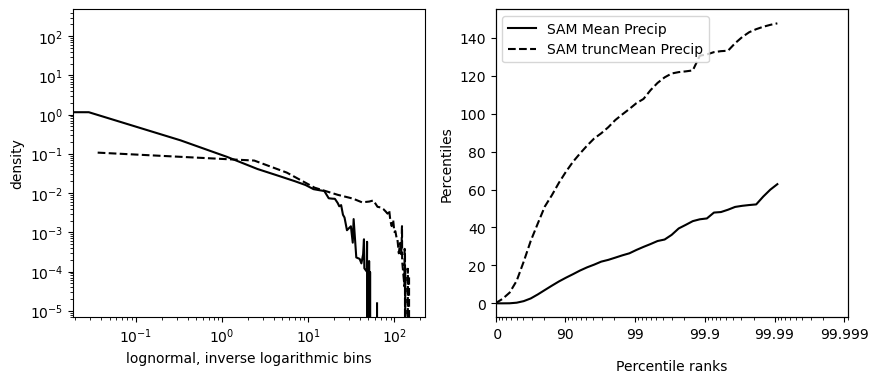

In [26]:
fig,axs = plt.subplots(ncols=2,figsize=(10,4))

# distribution on log-log
ax = axs[0]
ax.plot(dist_SAM_Prec_mean.percentiles,dist_SAM_Prec_mean.density,'k',label='no noise')
ax.plot(dist_SAM_Prec_truncMean.percentiles,dist_SAM_Prec_truncMean.density,'k--',label='w/ noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('lognormal, inverse logarithmic bins')
ax.set_ylabel('density')

# distribution on inverse logarithmic ranks
ax = axs[1]
_,h1 = subplotRanksILog(ax,dist_SAM_Prec_mean.ranks,dist_SAM_Prec_mean.percentiles,col='k',ltype='-',labels='SAM Mean Precip')
_,h2 = subplotRanksILog(ax,dist_SAM_Prec_truncMean.ranks,dist_SAM_Prec_truncMean.percentiles,col='k',ltype='--',labels='SAM truncMean Precip',setframe=False) 

ax.set_xlabel('Percentile ranks',labelpad=30)
ax.set_ylabel('Percentiles')

plt.legend(loc='upper left',handles=h1+h2)
plt.show()

In [35]:
# Joint distribution
jd_y1y2_IL = cs.JointDistribution(name='xy',distribution1=dist_SAM_Prec_mean,distribution2=dist_SAM_Prec_truncMean)
jd_y1y2_IL.computeNormalizedDistribution(ds_SAM_Prec_mean.reshape(n_days, 4, 64), ds_SAM_Prec_truncMean.reshape(n_days, 4, 64))

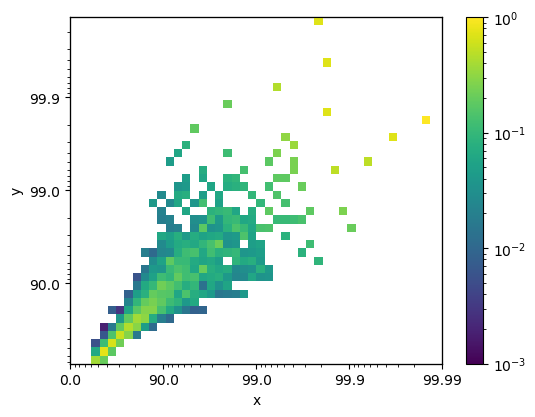

In [36]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_mean.ranks, dist_SAM_Prec_truncMean.ranks) ## the given ax object must not be ax_show. 

# values
Z = jd_y1y2_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

## SAM : Max vs Trunc Mean

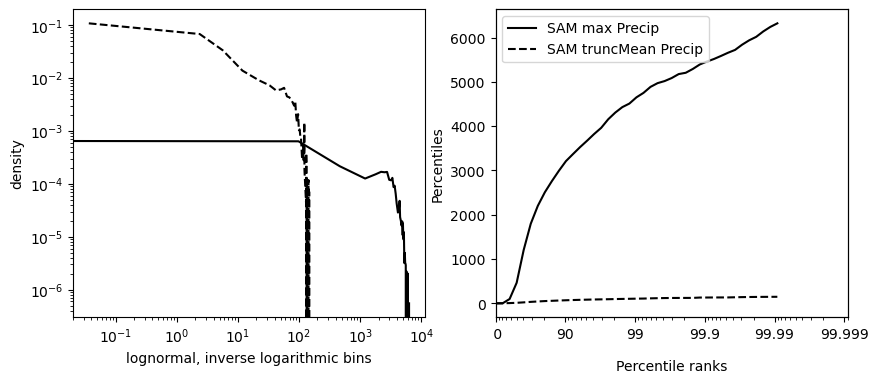

In [29]:
fig,axs = plt.subplots(ncols=2,figsize=(10,4))

# distribution on log-log
ax = axs[0]
ax.plot(dist_SAM_Prec_max.percentiles,dist_SAM_Prec_max.density,'k',label='no noise')
ax.plot(dist_SAM_Prec_truncMean.percentiles,dist_SAM_Prec_truncMean.density,'k--',label='w/ noise')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('lognormal, inverse logarithmic bins')
ax.set_ylabel('density')

# distribution on inverse logarithmic ranks
ax = axs[1]
_,h1 = subplotRanksILog(ax,dist_SAM_Prec_max.ranks,dist_SAM_Prec_max.percentiles,col='k',ltype='-',labels='SAM max Precip')
_,h2 = subplotRanksILog(ax,dist_SAM_Prec_truncMean.ranks,dist_SAM_Prec_truncMean.percentiles,col='k',ltype='--',labels='SAM truncMean Precip',setframe=False) 

ax.set_xlabel('Percentile ranks',labelpad=30)
ax.set_ylabel('Percentiles')

plt.legend(loc='upper left',handles=h1+h2)
plt.show()

In [30]:
# Joint distribution
jd_y1y2_IL = cs.JointDistribution(name='max_truncMean',distribution1=dist_SAM_Prec_max,distribution2=dist_SAM_Prec_truncMean)
jd_y1y2_IL.computeDistribution(ds_SAM_Prec_max, ds_SAM_Prec_truncMean)

/home/mcarenso/.conda/envs/PyLMD/lib/python3.8/site-packages/numpy/lib/histograms.py:1122: RuntimeWarning: invalid value encountered in true_divide
  hist = hist / dedges[i].reshape(shape)


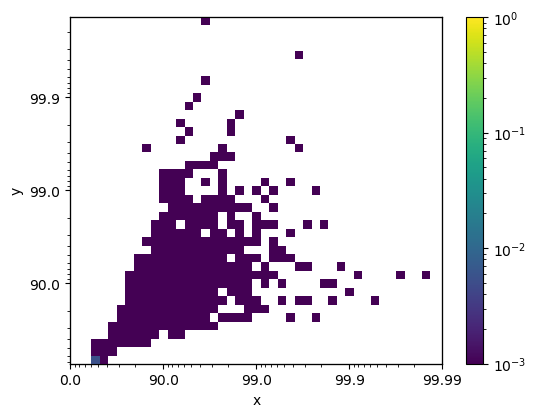

In [31]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec_max.ranks, dist_SAM_Prec_truncMean.ranks) ## the given ax object must not be ax_show. 

# values
Z = jd_y1y2_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

## SAM : Raw vs Mean

In [32]:
ds_SAM = xr.open_dataset(sam_dir_path+"rcemip_large_2048x128x74_3km_12s_300K_64.2Dcom_1.nc")
ds_SAM = ds_SAM.isel(time=slice(48*n_days)) #.isel(x=slice(64, None))
ds_SAM["x"] = ((ds_SAM["x"])/3e3).astype(int)
ds_SAM["y"] = (ds_SAM["y"]/3e3).astype(int) 
ds_SAM["time"] = np.round(((ds_SAM["time"]-75)*48)).astype(int) 

ds_SAM_shape= ds_SAM["Prec"].shape
#ds_SAM_Prec = ds_SAM["Prec"].stack(flat=('time', 'y', 'x')).to_numpy()
#ds_SAM_Prec.reshape(ds_SAM_shape) ## to retrieve the PRec in original shape or ds_SAM["Prec"].to_numpy()
dist_SAM_Prec = cs.Distribution(name="SAM Precipitation", bintype = "invlogQ", nd = 3, fill_last_decade=True)
dist_SAM_Prec.computeDistribution(sample = ds_SAM["Prec"].stack(flat=('time', 'y', 'x')).to_numpy())

MemoryError: Unable to allocate 1.88 GiB for an array with shape (960, 128, 2048) and data type int64

In [ ]:
# Joint distribution
jd_Raw_vs_Mean_IL = cs.JointDistribution(name='raw_mean',distribution1=dist_SAM_Prec,distribution2=dist_SAM_Prec_mean)
jd_Raw_vs_Mean_IL.computeNormalizedDistribution(ds_SAM["Prec"].to_numpy(), ds_SAM_Prec_mean.reshape(n_days, 4, 64))

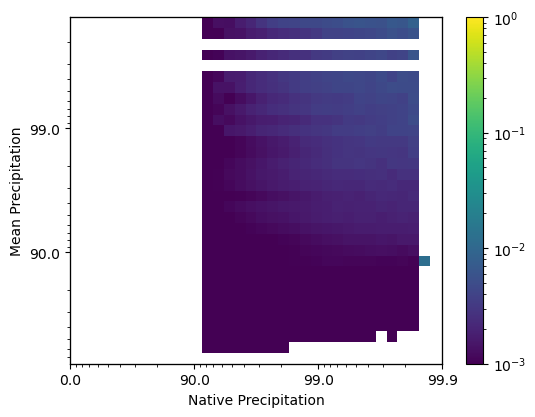

In [ ]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec.ranks, dist_SAM_Prec_mean.ranks, xlabel = "Native Precipitation", ylabel = "Mean Precipitation") ## the given ax object must not be ax_show. 

# values
Z = jd_Raw_vs_Mean_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

## SAM : Raw vs Max

In [ ]:
# Joint distribution
jd_Raw_vs_Max_IL = cs.JointDistribution(name='raw_max',distribution1=dist_SAM_Prec,distribution2=dist_SAM_Prec_max)
jd_Raw_vs_Max_IL.computeNormalizedDistribution(ds_SAM["Prec"].to_numpy(), ds_SAM_Prec_max.reshape(n_days, 4, 64))

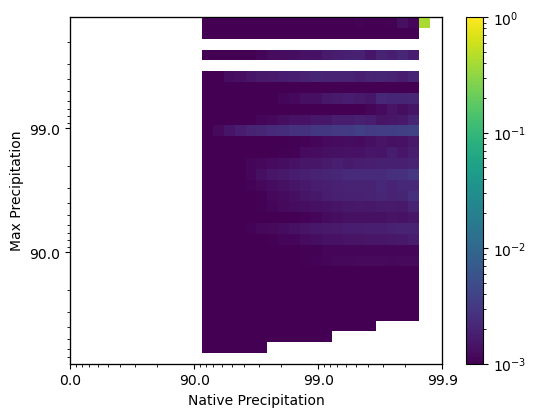

In [ ]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec.ranks, dist_SAM_Prec_max.ranks, xlabel = "Native Precipitation", ylabel = "Max Precipitation") ## the given ax object must not be ax_show. 

# values
Z = jd_Raw_vs_Max_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

## SAM : Raw : vs TruncMean

In [ ]:
# Joint distribution
jd_Raw_vs_TruncMean_IL = cs.JointDistribution(name='raw_max',distribution1=dist_SAM_Prec,distribution2=dist_SAM_Prec_truncMean)
jd_Raw_vs_TruncMean_IL.computeNormalizedDistribution(ds_SAM["Prec"].to_numpy(), ds_SAM_Prec_truncMean.reshape(n_days, 4, 64))

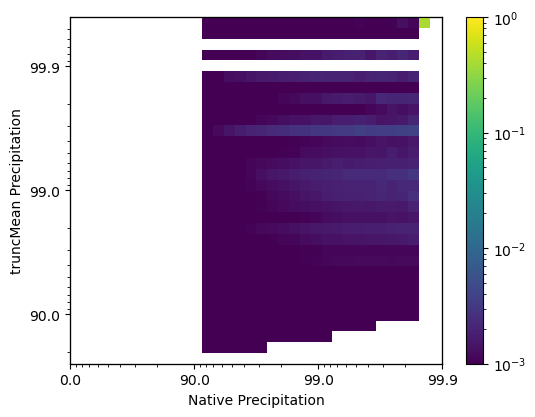

In [ ]:
# Show joint distribution
# frame IL
fig,ax = plt.subplots(figsize=(6,4.5))
ax_show = ax.twinx().twiny()
ax = setFrameIL(ax, dist_SAM_Prec.ranks, dist_SAM_Prec_truncMean.ranks, xlabel = "Native Precipitation", ylabel = "truncMean Precipitation") ## the given ax object must not be ax_show. 

# values
Z = jd_Raw_vs_Max_IL.density.T
h = showJointHistogram(ax_show, Z, scale = 'log') ## Here the given ax object must be ax_show. that's what it means "regardless of preset frame and ticks"

plt.colorbar(h)
plt.show()

In [ ]:
print("Goodbye world !")

Goodbye world !
